In [66]:
import numpy as np
import torch
import os
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.autograd import Variable
from scipy.optimize import linear_sum_assignment
import cv2
from torch.utils.data import DataLoader
from tracktor.datasets.factory import Datasets
from tracktor.config import get_output_dir
from torchvision.ops.boxes import clip_boxes_to_image, nms
import pandas as pd
import numba
from numba import int16, jit, int32
import numpy as np
import time
from scipy.signal import correlate
from scipy.ndimage import convolve1d

import os
os.chdir(r"C:\Data Science\Thesis\ba_keypoints\tracking_wo_bnw")

from fg_detector.fg_detector import FGDetector, offset_image
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:

dataset_name="mot17_test_FRCNN17"
dataset = Datasets(dataset_name)
seq = dataset[0]
print(seq)

MOT17-01-FRCNN


In [68]:
import sacred
from sacred import Experiment
ex = Experiment(name="from notebook",interactive=True)
ex.add_config('experiments/cfgs/fg_det.yaml')
configuration = ex.configurations[0]._conf
configuration['fg_detector']

{'color_scale_factor': 4,
 'desription': None,
 'fg_delta_mu': 600,
 'fg_delta_sigma': 40,
 'frame_interval': 20,
 'frame_split': [0.0, 1.0],
 'grid': 200,
 'interpolate': False,
 'length': 40,
 'module_name': 'MOT17',
 'n_best': 10,
 'name': 'Tracktor++',
 'seed': 12345,
 'sigma': 5,
 'write_images': False}

In [69]:
fg_det=FGDetector(configuration['fg_detector'], seq)
fg_det.calc_average_image()
grid_points=fg_det.calc_grid_points()
positions= fg_det.calc_positions()
positions

array([[ 0,  0],
       [ 0, -1],
       [ 0, -2],
       [ 0, -1],
       [ 0,  0],
       [ 0, -2],
       [ 1, -2],
       [ 0,  2],
       [ 0,  4],
       [ 0,  2],
       [ 0,  2],
       [ 0,  4],
       [-1,  7],
       [ 0,  6],
       [ 0,  4],
       [ 0,  6],
       [ 0,  9],
       [ 0,  9],
       [ 0,  8],
       [ 0,  9],
       [ 0,  9],
       [ 0,  9],
       [ 1,  7]], dtype=int64)

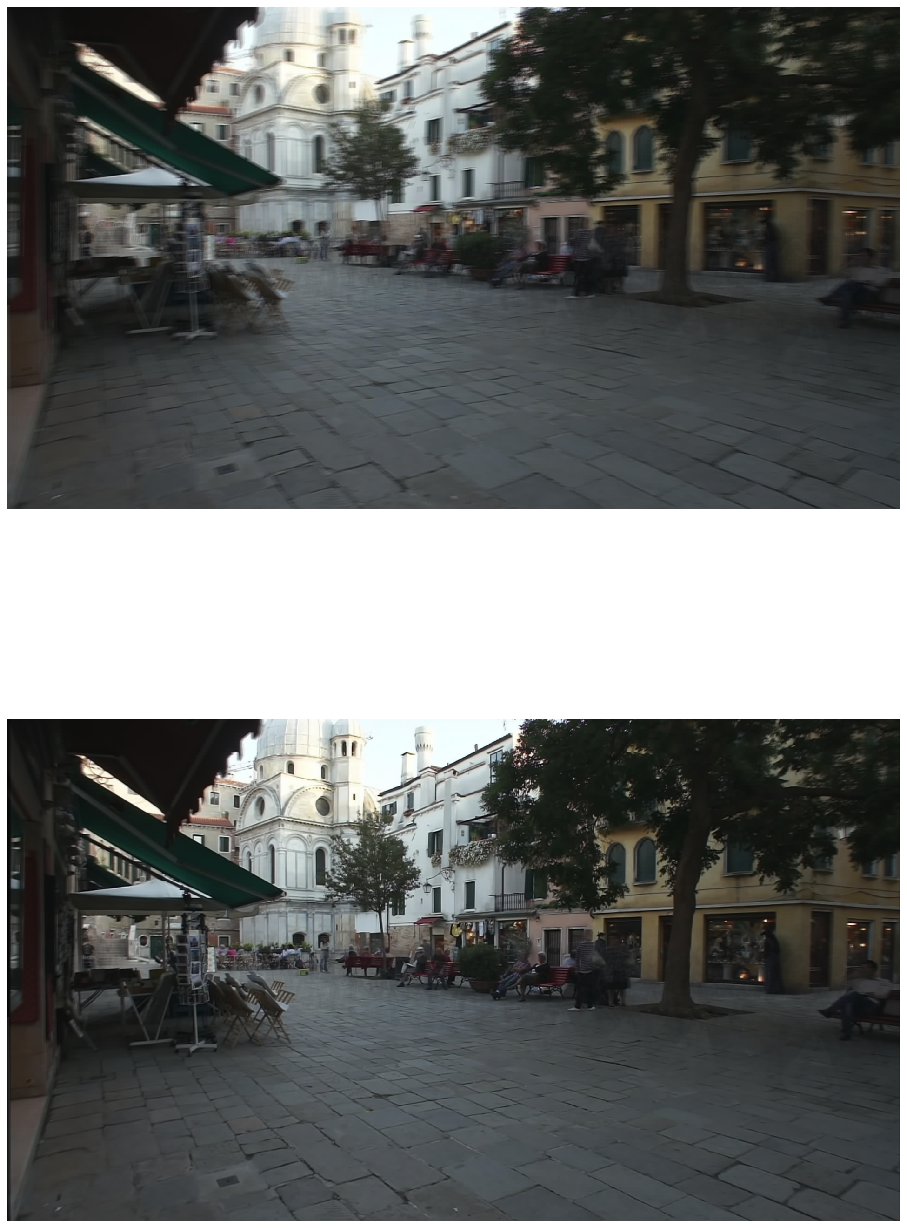

In [70]:
f = plt.figure(figsize=(16,24))
ax0 = f.add_subplot(211)
ax1 = f.add_subplot(212)
average_imaged=fg_det.calc_average_image(None)
ax0.imshow(np.swapaxes(np.swapaxes(average_imaged, 0, 2),1,0))
average_imaged=fg_det.calc_average_image(positions)
ax1.imshow(np.swapaxes(np.swapaxes(average_imaged, 0, 2),1,0))
ax0.set_axis_off()
ax1.set_axis_off()
plt.show()

In [71]:
fg_det.calc_histograms()
bg= fg_det.calc_bg()


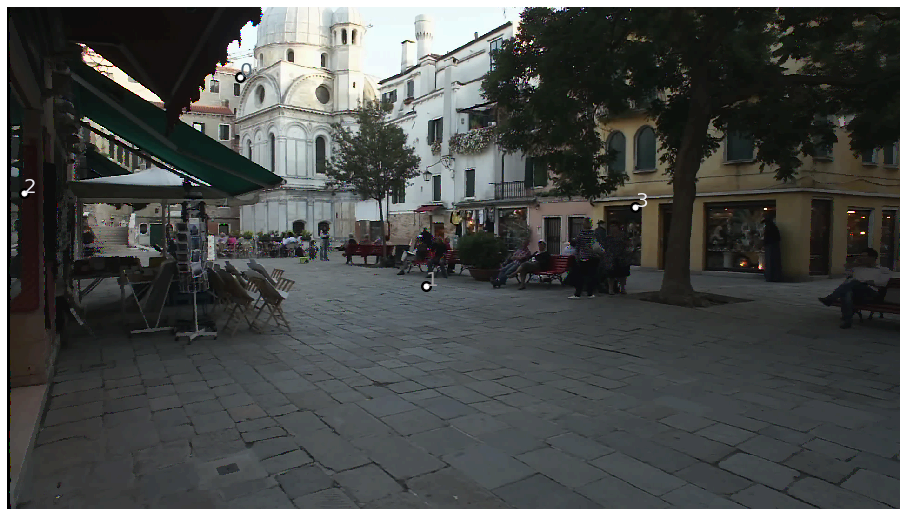

In [72]:
points= [[500,150],[900,600],[35,400],[1350,430]]

im2show=np.swapaxes(np.swapaxes(bg[0], 0, 2),1,0)
plt.figure(figsize = (16,12))
plt.imshow(im2show)
plt.axis('off')

for i,p in enumerate(points):
    x=p[0]
    y=p[1]
    color=(im2show[y,x]/256)
    plt.scatter(x,y,s=100,c='k')
    plt.scatter(x,y,s=25,c='w')
    plt.text(x,y,s=f"{i}",c=1-color, fontsize=20)
plt.show()

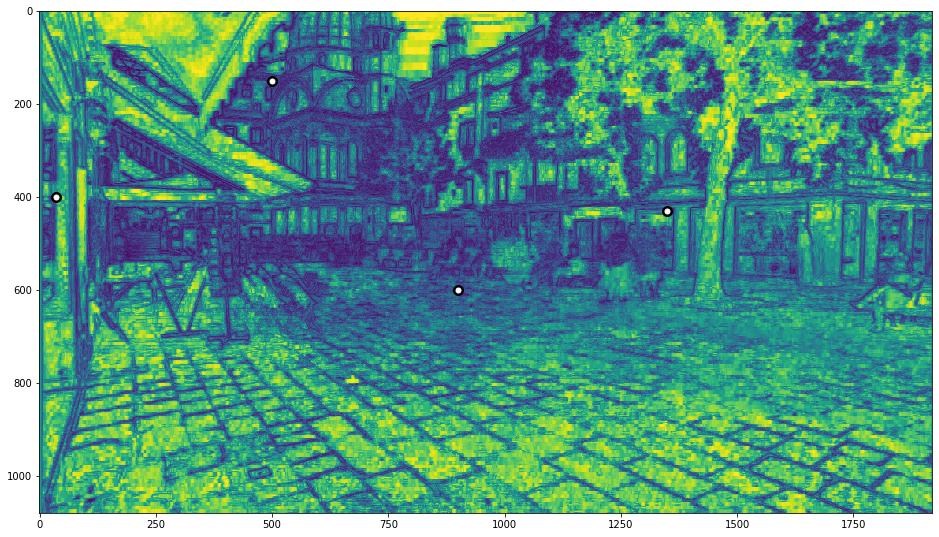

In [73]:
hm2show=8*np.swapaxes(np.swapaxes(bg[1], 0, 2),1,0)
plt.figure(figsize = (16,12))
hm2show_grey=np.sum(hm2show,axis=2)
plt.imshow(hm2show_grey)
for p in points:
    x=p[0]
    y=p[1]
    plt.scatter(x,y,s=100,c='k')
    plt.scatter(x,y,s=25,c='w')
plt.show()

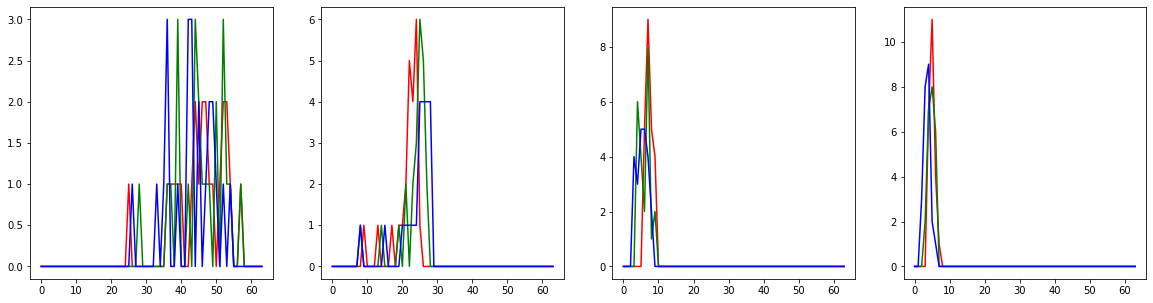

In [74]:
f= plt.figure(figsize = (20,5))

for i, p in enumerate(points):
    ax = f.add_subplot(1,len(points),i+1)
    x=p[0]
    y=p[1]

    ax.plot(fg_det.all_histograms[:,0,y,x],c='r')
    ax.plot(fg_det.all_histograms[:,1,y,x],c='g')
    ax.plot(fg_det.all_histograms[:,2,y,x],c='b')
plt.show()